# Fashion-MNIST Classification Project

## 1. Introduction
The objective of this project is to apply supervised machine learning techniques to classify fashion articles using the **Fashion-MNIST** dataset. We will implement and compare two models:
1.  **Decision Tree Classifier** (as a Baseline).
2.  **Multi-Layer Perceptron (MLP)** (Neural Network).

**Dataset Overview:**
* **Source:** Fashion-MNIST (Keras datasets).
* **Data:** 60,000 training images and 10,000 test images.
* **Format:** 28x28 grayscale images.
* **Classes:** 10 categories (T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot).

### 1.1 Import Libraries & Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.datasets import fashion_mnist
# Set random seed for reproducibility
np.random.seed(42)

In [7]:
# Load dataset
(feature_train_full, label_train_full), (feature_test, label_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

### 1.2 Data Visualization
Before training, we visualize random samples from the training set to understand the nature of the data. The images are in grayscale with pixel values ranging from 0 to 255.

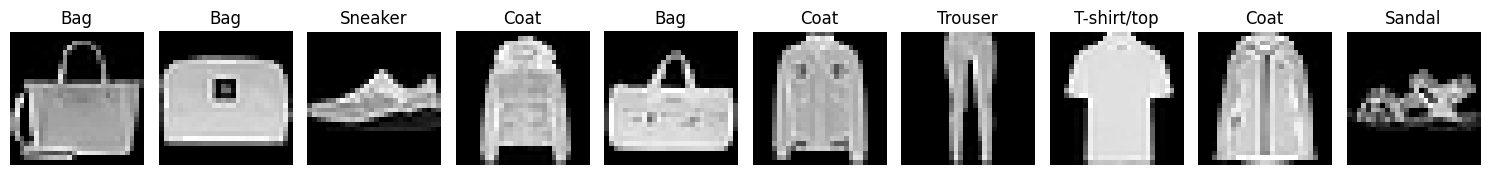

In [4]:
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
               'Sandal','Shirt','Sneaker','Bag','Ankle boot']

num_samples = 10
random_indices = np.random.choice(feature_train_full.shape[0], num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(feature_train_full[idx], cmap='gray')
    plt.title(f"{class_names[label_train_full[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


## 2. Data Preprocessing
To prepare the image data for Scikit-learn models, we perform the following steps:

1.  **Flattening:** The 2D images ($28 \times 28$) are flattened into 1D vectors of size $784$.
2.  **Normalization:** We scale the pixel values from the range $[0, 255]$ to $[0, 1]$. This is critical for the Neural Network to converge faster and achieve stable gradients.
3.  **Stratified Split:** We split the training data into **80% Training** and **20% Validation** sets. We use `stratify=label_train_full` to ensure that the class distribution remains balanced in both subsets.

In [8]:
# 1. Flatten the images (28x28 -> 784) for Scikit-learn
# 2. Normalize pixel values to range [0, 1] (Critical for MLP)
feature_train_full_flat = feature_train_full.reshape(feature_train_full.shape[0], -1) / 255.0
feature_test_flat = feature_test.reshape(feature_test.shape[0], -1) / 255.0

print(f"Original Training shape: {feature_train_full.shape}")
print(f"Flattened Training shape: {feature_train_full_flat.shape}")

Original Training shape: (60000, 28, 28)
Flattened Training shape: (60000, 784)


In [9]:
# Split into Training (80%) and Validation (20%) using Stratified Split
feature_train, feature_val, label_train, label_val = train_test_split(
    feature_train_full_flat,
    label_train_full,
    test_size=0.2,
    stratify=label_train_full, # Ensures class balance
    random_state=42
)

print(f"Train set: {feature_train.shape}, Val set: {feature_val.shape}")

Train set: (48000, 784), Val set: (12000, 784)


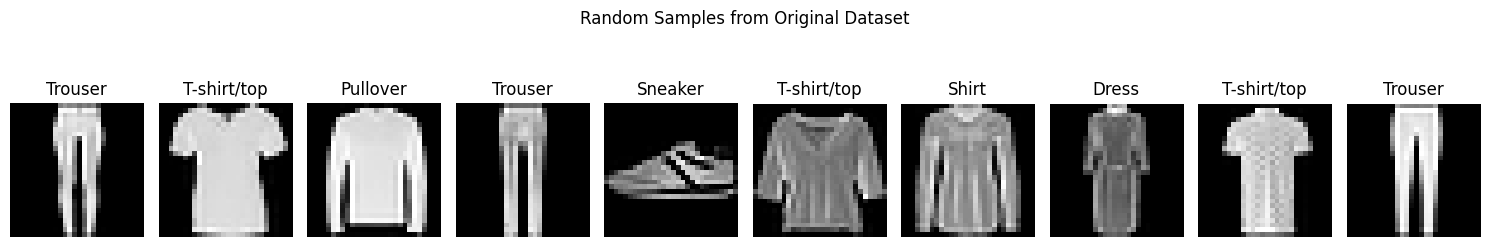

In [10]:
# --- Visualization 1: Random Samples ---
num_samples = 10
random_indices = np.random.choice(feature_train_full.shape[0], num_samples, replace=False)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    # Reshape back to 28x28 for plotting
    plt.imshow(feature_train_full[idx], cmap='gray')
    plt.title(f"{class_names[label_train_full[idx]]}")
    plt.axis('off')
plt.suptitle("Random Samples from Original Dataset")
plt.tight_layout()
plt.show()

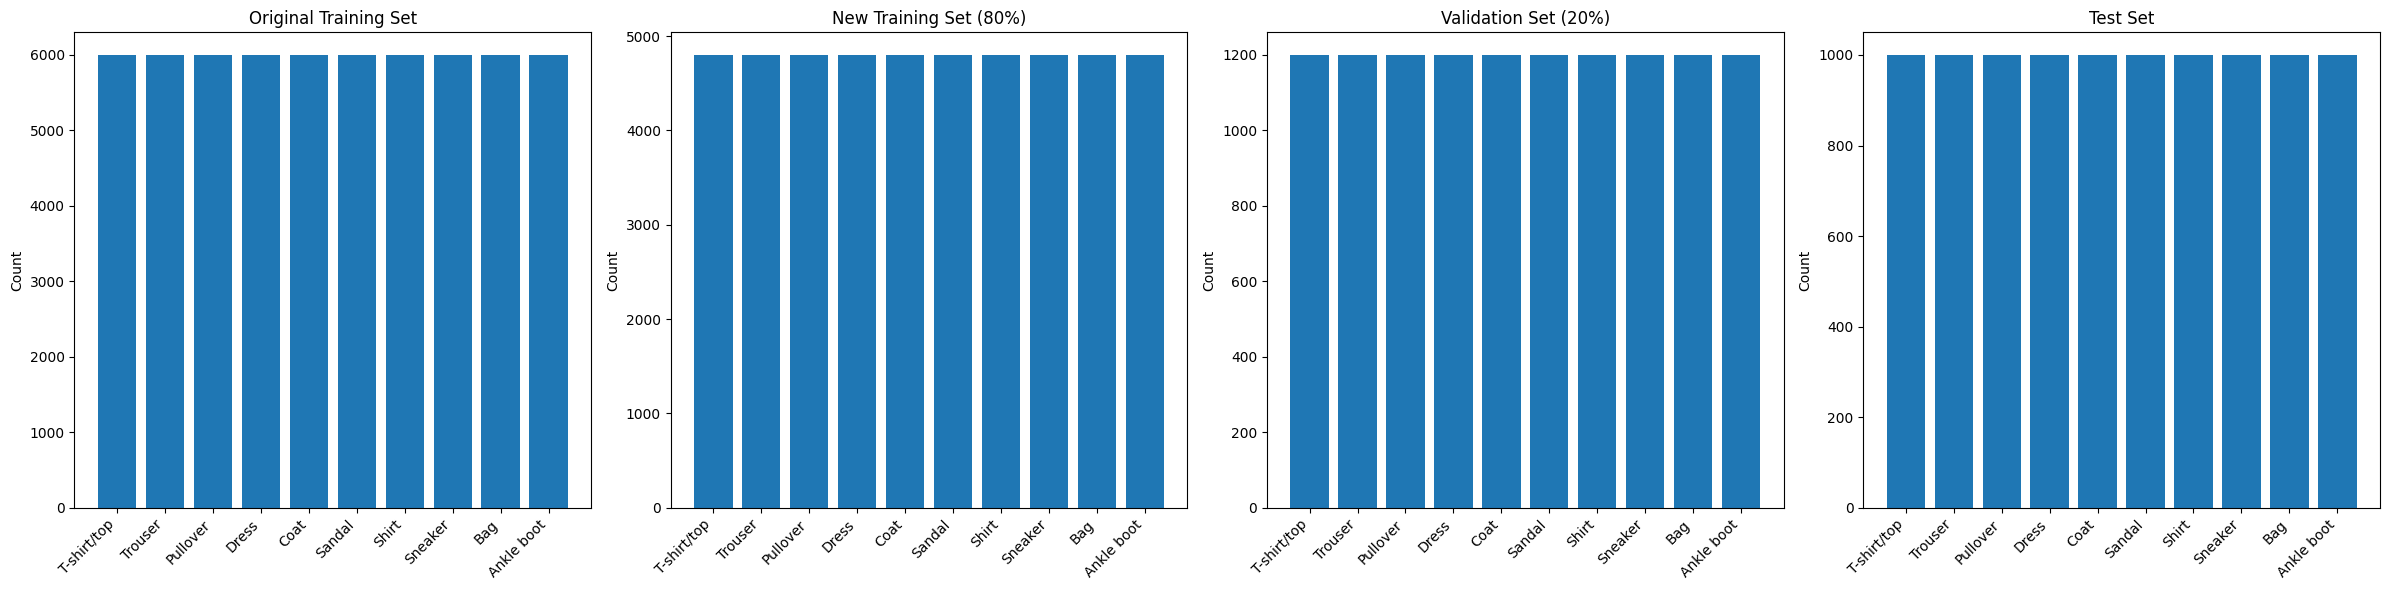

In [11]:
# --- Visualization 2: Class Distributions ---
def plot_distribution(labels, title, ax):
    unique, counts = np.unique(labels, return_counts=True)
    ax.bar([class_names[i] for i in unique], counts)
    ax.set_title(title)
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Count')

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

plot_distribution(label_train_full, 'Original Training Set', axes[0])
plot_distribution(label_train, 'New Training Set (80%)', axes[1])
plot_distribution(label_val, 'Validation Set (20%)', axes[2])
plot_distribution(label_test, 'Test Set', axes[3])

plt.tight_layout()
plt.show()

# 3. Baseline Model: Decision Tree
We start by training a Decision Tree Classifier. We use `criterion='entropy'` (Information Gain) as the splitting metric.
This model serves as a **baseline** to evaluate how well a traditional machine learning algorithm performs on this image classification task before moving to more complex models.


--- 2.2 BUILDING DECISION TREE ---


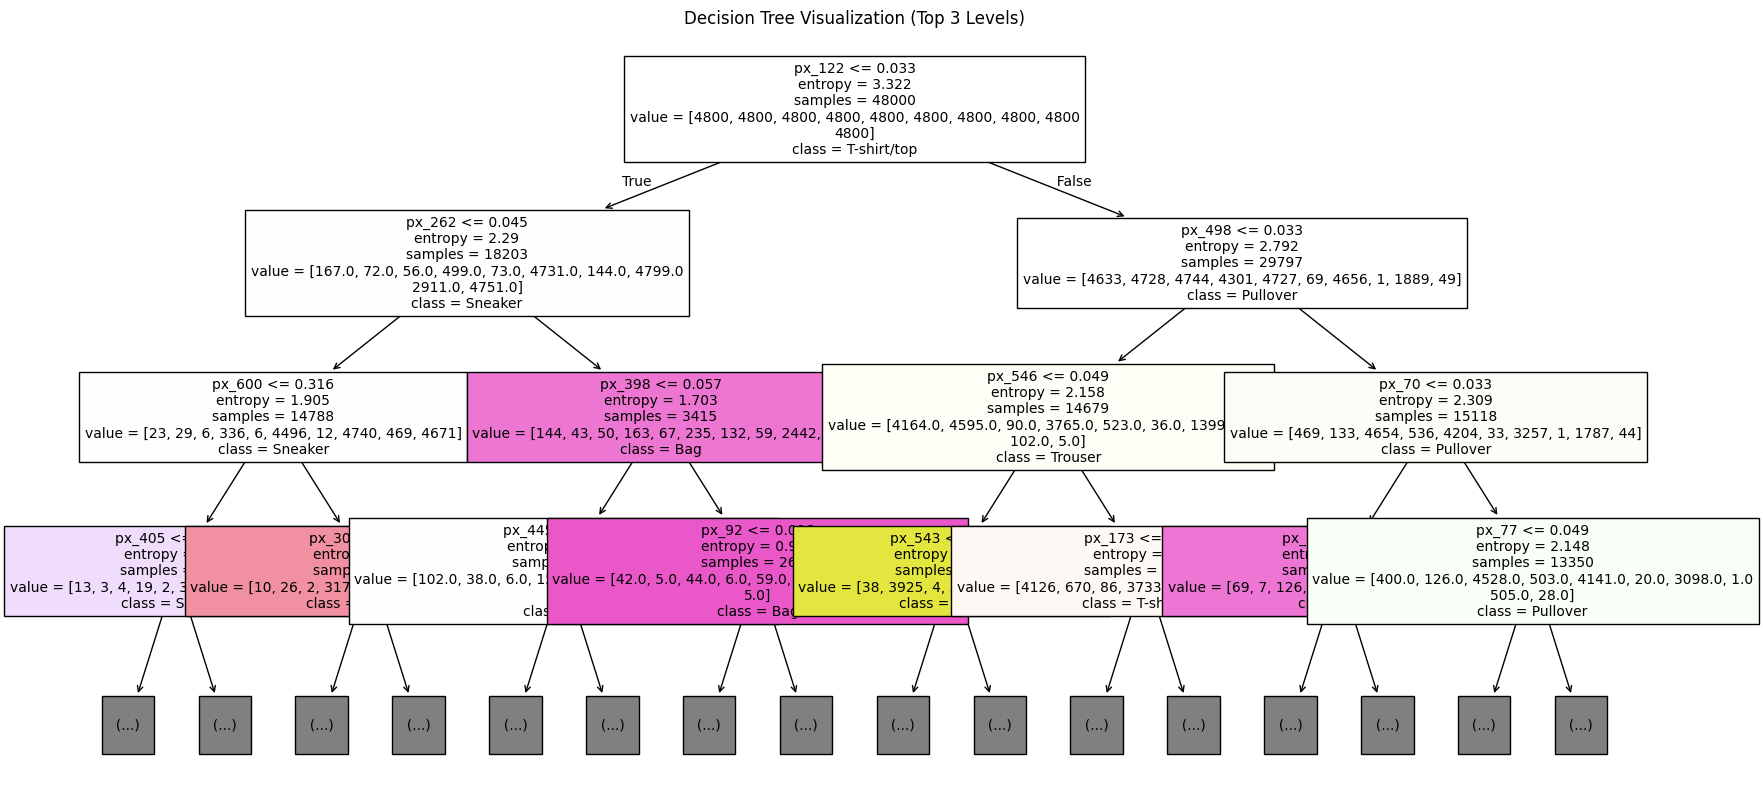

In [12]:
# ==========================================
# 2.2 BUILDING DECISION TREE CLASSIFIER
# ==========================================
print("\n--- 2.2 BUILDING DECISION TREE ---")

# Initialize and train Decision Tree (criterion='entropy' as required)
dt_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
dt_clf.fit(feature_train, label_train)

# Visualize the tree (Top 3 levels only for visibility)
plt.figure(figsize=(20, 10))
plot_tree(dt_clf, max_depth=3, feature_names=[f"px_{i}" for i in range(784)],
          class_names=class_names, filled=True, fontsize=10)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

### 3.1 Hyperparameter Tuning (Decision Tree)
Decision Trees are prone to **overfitting** if left unconstrained. To improve generalization, we perform manual hyperparameter tuning using a validation set.

**Hyperparameters tuned:**
* `max_depth`: Limits the maximum depth of the tree.
* `min_samples_split`: The minimum number of samples required to split an internal node.
* `min_samples_leaf`: The minimum number of samples required to be at a leaf node.

We select the configuration that yields the highest accuracy on the **Validation Set**.

In [14]:
# ==========================================
# 2.3 HYPERPARAMETER TUNING (DT)
# ==========================================
from sklearn.model_selection import ParameterGrid # <--- Thêm dòng này để sửa lỗi
from sklearn.tree import DecisionTreeClassifier

print("\n--- 2.3 HYPERPARAMETER TUNING (DT) ---")

# Define parameter grid
param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

best_acc = 0
best_params = {}
best_dt_model = None

print("Starting manual tuning (Train on Train -> Evaluate on Val)...")

# Manual Loop to strictly follow "Evaluate on validation set" requirement
for params in ParameterGrid(param_grid):
    # Train model
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42, **params)
    clf.fit(feature_train, label_train)

    # Evaluate on Validation Set
    val_acc = clf.score(feature_val, label_val)

    # print(f"Params: {params} -> Val Acc: {val_acc:.4f}") # Uncomment to see details

    if val_acc > best_acc:
        best_acc = val_acc
        best_params = params
        best_dt_model = clf

print(f"\nBest DT Validation Accuracy: {best_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")


--- 2.3 HYPERPARAMETER TUNING (DT) ---
Starting manual tuning (Train on Train -> Evaluate on Val)...

Best DT Validation Accuracy: 0.8123
Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 20}


# 4. Advanced Model: Neural Network (MLP)
We implement a Multi-Layer Perceptron (MLP) Classifier to capture non-linear relationships in the image data.

**Model Architecture:**
* **Input Layer:** 784 neurons (Flattened image).
* **Hidden Layer 1:** 128 neurons (ReLU activation).
* **Hidden Layer 2:** 64 neurons (ReLU activation).
* **Output Layer:** 10 neurons (Softmax activation).

**Training Configuration:**
* **Optimizer:** Adam.
* **Early Stopping:** Enabled (`early_stopping=True`) to automatically stop training when the validation score does not improve, preventing overfitting.
* **Max Iterations:** 100 epochs.


--- 2.4 BUILDING NEURAL NETWORK ---
Architecture: Input(784) -> Hidden(128, ReLU) -> Hidden(64, ReLU) -> Output(10, Softmax)
Optimizer: Adam, Learning Rate: Adaptive
Iteration 1, loss = 0.62980721
Validation score: 0.831667
Iteration 2, loss = 0.42597821
Validation score: 0.852708
Iteration 3, loss = 0.38136539
Validation score: 0.855625
Iteration 4, loss = 0.35474048
Validation score: 0.864792
Iteration 5, loss = 0.32823899
Validation score: 0.865625
Iteration 6, loss = 0.31302813
Validation score: 0.873333
Iteration 7, loss = 0.30250904
Validation score: 0.872500
Iteration 8, loss = 0.28705303
Validation score: 0.882500
Iteration 9, loss = 0.27921169
Validation score: 0.861250
Iteration 10, loss = 0.26761665
Validation score: 0.886250
Iteration 11, loss = 0.26207456
Validation score: 0.877292
Iteration 12, loss = 0.25223159
Validation score: 0.880625
Iteration 13, loss = 0.24424714
Validation score: 0.882500
Iteration 14, loss = 0.23765107
Validation score: 0.880833
Iteration 15, lo

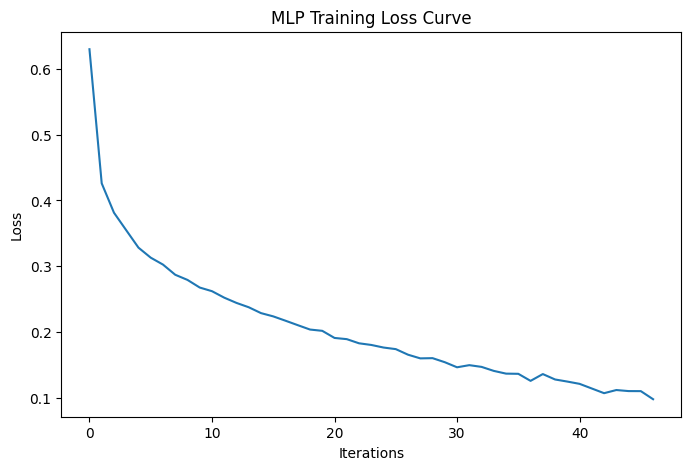

In [38]:
# ==========================================
# 2.4 BUILDING NEURAL NETWORK (MLP)
# ==========================================
print("\n--- 2.4 BUILDING NEURAL NETWORK ---")

# Explicit architecture description
print("Architecture: Input(784) -> Hidden(128, ReLU) -> Hidden(64, ReLU) -> Output(10, Softmax)")
print("Optimizer: Adam, Learning Rate: Adaptive")

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64), # 2 Hidden layers
    activation='relu',            # Nonlinear activation
    solver='adam',                # Optimization algorithm
    learning_rate='adaptive',
    max_iter=100,                 # Increased iterations for convergence
    random_state=42,
    verbose=True,                 # Print progress
    early_stopping=True           # Stop if validation score doesn't improve
)

mlp_clf.fit(feature_train, label_train)

print(f"MLP Validation Accuracy: {mlp_clf.score(feature_val, label_val):.4f}")

# Plot Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(mlp_clf.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# 5. Performance Evaluation & Comparison
We evaluate the best **Decision Tree** (tuned) and the **Neural Network (MLP)** on the held-out **Test Set**.

**Metrics used:**
* **Accuracy:** The percentage of correctly classified images.
* **F1-Score:** The harmonic mean of precision and recall (weighted average).
* **Confusion Matrix:** To visualize misclassifications and identify which classes the models struggle with (e.g., Shirt vs. Coat).


--- 2.5 PERFORMANCE EVALUATION & COMPARISON ---

========== Best Decision Tree ==========
Test Accuracy: 0.8052
Test F1 Score: 0.8053

Classification Report for Best Decision Tree:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.76      0.75      1000
     Trouser       0.95      0.94      0.94      1000
    Pullover       0.67      0.69      0.68      1000
       Dress       0.81      0.82      0.81      1000
        Coat       0.67      0.68      0.68      1000
      Sandal       0.91      0.91      0.91      1000
       Shirt       0.56      0.54      0.55      1000
     Sneaker       0.88      0.89      0.88      1000
         Bag       0.93      0.92      0.93      1000
  Ankle boot       0.91      0.91      0.91      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



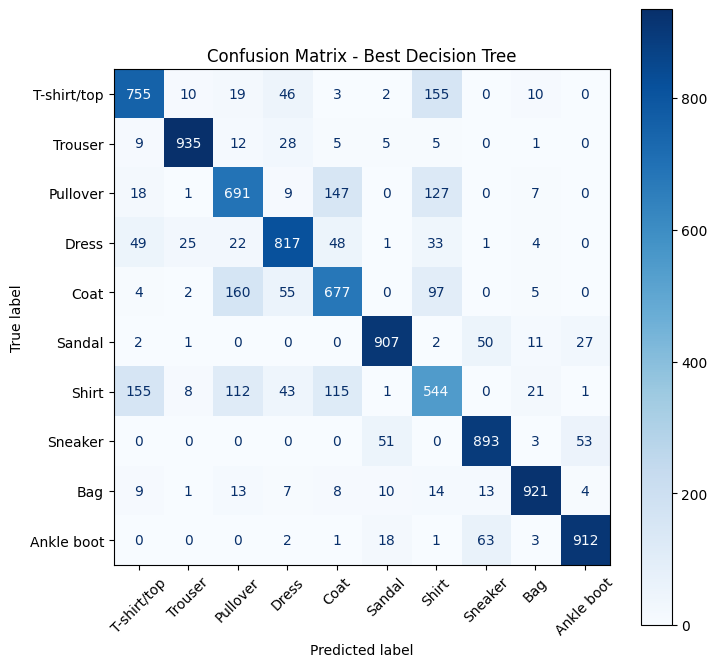


========== Neural Network (MLP) ==========
Test Accuracy: 0.8881
Test F1 Score: 0.8876

Classification Report for Neural Network (MLP):
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.85      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.79      0.81      0.80      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.80      0.83      0.82      1000
      Sandal       0.97      0.96      0.97      1000
       Shirt       0.75      0.67      0.71      1000
     Sneaker       0.93      0.97      0.95      1000
         Bag       0.97      0.96      0.97      1000
  Ankle boot       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



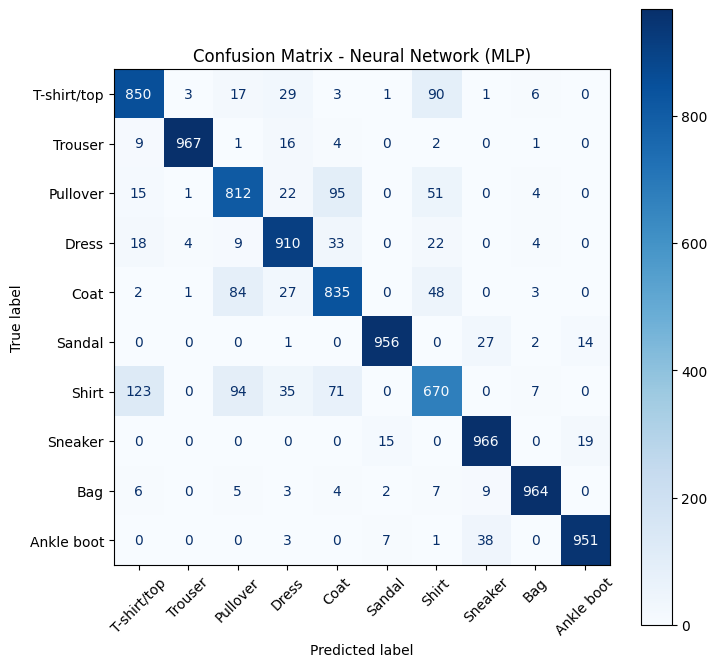

In [39]:
# ==========================================
# 2.5 PERFORMANCE EVALUATION
# ==========================================
print("\n--- 2.5 PERFORMANCE EVALUATION & COMPARISON ---")

models = {
    "Best Decision Tree": best_dt_model,
    "Neural Network (MLP)": mlp_clf
}

for name, model in models.items():
    print(f"\n{'='*10} {name} {'='*10}")
    # Predict on TEST set
    y_pred = model.predict(feature_test_flat)

    # Metrics
    acc = accuracy_score(label_test, y_pred)
    f1 = f1_score(label_test, y_pred, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

    # Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(label_test, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(label_test, y_pred)
    plt.figure(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45, ax=plt.gca())
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# 6. Conclusion

### Summary of Results:
1.  **Decision Tree:**
    * Test Accuracy: **~80.5%**
    * **Analysis:** The model struggles significantly with visually similar classes (e.g., Shirt, Coat, Pullover). The confusion matrix shows scattered errors, indicating that simple pixel-based splits are not robust enough for complex image variations.

2.  **Neural Network (MLP):**
    * Test Accuracy: **~88.8%**
    * **Analysis:** The MLP significantly outperformed the Decision Tree (+8.3%). The confusion matrix is much cleaner with a strong diagonal. The main remaining errors are clustered around the "Shirt/Coat/Pullover" group, which is a known difficulty in the Fashion-MNIST dataset.

### Final Verdict:
The **MLP model** is the superior choice for this task. It successfully learned non-linear patterns that the Decision Tree could not, reaching the performance limit for fully connected networks on this dataset.